# We are a promoting company, and our aim is to gather the most distinct info out of the dataset so as to find ways of implementing ads into games

In [20]:
import pandas as pd
data = pd.read_csv('steam.csv') 
data

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19


#1) If we were working on a weak machine, would be there a significant difference in case of using only 1/27 part of a dataset?
#Use Monte-Carlo method for the research :)

In [21]:
#random selector
from random import *

err_list = []
for k in range(50):
  sum_of_1000_prices = 0
  for i in range(1000):
    sum_of_1000_prices += data.loc[choice([x for x in range(0, data.shape[0])])].price
  #print(f"Mean by Monte-Carlo method: {sum_of_1000_prices/1000}\nActual mean of prices: {data.price.mean()}\nError: {sum_of_1000_prices/1000-data.price.mean()}")
  err_list.append(sum_of_1000_prices/1000-data.price.mean())

err_series = pd.Series(err_list)
err_series.apply("abs").describe()



count    50.000000
mean      0.185879
std       0.134366
min       0.007917
25%       0.098789
50%       0.155665
75%       0.261868
max       0.614327
dtype: float64

Conclusion: yup, we may use only a part of the whole dataset if there's such a need!

# 2) Forming two hypothesis:
## H0 - there's no statistically significant difference between time spent either in paid or free games.
## Н1 - there is a statistically significant difference between time spent either in paid or free games.
##***we'll use the x-squared criteria for testing***

In [22]:
from datetime import datetime
date_format = "%Y-%m-%d"
today = datetime.strptime('2022-10-01', date_format)

l = []
for i in range(data.shape[0]):
  l.append(data.average_playtime[i]/(((today-datetime.strptime(data.release_date[i], date_format)).days + 1)*24))
data["AVGP/TIME"] = l

paid_of, paid_rar, free_of, free_rar = data[(data["AVGP/TIME"] > 0.0001) & (data.price != 0)]["name"].count(), data[(data["AVGP/TIME"] <= 0.0001) & (data.price != 0)]["name"].count(), data[(data["AVGP/TIME"] > 0.0001) & (data.price == 0)]["name"].count(), data[(data["AVGP/TIME"] <= 0.0001) & (data.price == 0)]["name"].count()
samples = pd.DataFrame({"Paid":[paid_rar, paid_of, paid_rar+paid_of], "Free":[free_rar, free_of, free_rar+free_of], "Rows sum":[paid_rar+free_rar, paid_of+free_of, "NaN"]}, index=["Rarely", "Often", "Columns sum"])
samples


,Paid,Free,Rows sum
Rarely,19452,1853,21305
Often,5063,707,5770
Columns sum,24515,2560,NaN


In [23]:
f11, f12, f21, f22 = samples.Paid[2]*samples["Rows sum"][0]/data.shape[0], samples.Free[2]*samples["Rows sum"][0]/data.shape[0], samples.Paid[2]*samples["Rows sum"][1]/data.shape[0], samples.Free[2]*samples["Rows sum"][1]/data.shape[0]
frequences = [[f11, f12], [f21, f22]]
x_squared = 0

for i in range(2):
  for k in range(2):
    x_squared += (samples.iloc[i][k] - frequences[i][k])**2/frequences[i][k]    #67.04495253353966

''' with a = 0.01 confidence (that means 99% granted), the critical value of x-squared is 6.635 with 1 degree of freedom "DF" (because DF = (samples.shape[0] - 1)(samples.shape[1]-1) )'''
if x_squared <= 6.635:
  print(f"We cannot reject the H0 hypothesis, beacuse x-squared is less than a critical value: {round(x_squared, 3)} <= 6.635")
else:
  print(f"We reject the H0 hypothesis in favour of H1 hypothesis, because our x-squared value is: {round(x_squared, 3)} > 6.635")


We reject the H0 hypothesis in favour of H1 hypothesis, because our x-squared value is: 67.045 > 6.635


##**Conclusion**: *with 0.01 confidence level (99% for granted) we can say, that there **is** a statistically significant difference between the number of hours spent in either paid or free games.*

###in terms of putting ads into the games, there's little sense to implement them into free games, because users don't spend lots of time playing them. On the contrary, it will be much more profitable to insert ads into paid games.

# 3) Usage of 2 datasets (the second one contains support contacts for some games...) 

In [24]:
import ipywidgets as widgets
from IPython.display import display as d

support = pd.read_excel(r'steam_support_info.xlsx')

text = widgets.Text(
    placeholder='Enter game\'s name: ',
    description='Name')

button = widgets.Button(
    description='Search',
    button_style='info',
    tooltip='Search')

def selector(x):
    app_id = int(data[(data["name"] == text.value)]["appid"])
    print(2*"\n", pd.concat([data[data.appid == app_id].reset_index(), support[support.steam_appid == app_id].reset_index()], axis=1)[["name", "price", "median_playtime", "website"]])
button.on_click(selector)
d(text)
d(button)

Text(value='', description='Name', placeholder="Enter game's name: ")

Button(button_style='info', description='Search', style=ButtonStyle(), tooltip='Search')



         name  price  median_playtime  \
0  Rune Lord   5.19                0   

                                         website  
0  https://steamcommunity.com/groups/alawargames  


# 4) Is there any correlation between game's price and its quality?

In [25]:
platforms_research = data

mac_game_price = platforms_research[(platforms_research["platforms"] == 'mac') & (platforms_research.price != 0)].price.mean()
win_game_price = platforms_research[(platforms_research["platforms"] == 'windows') & (platforms_research.price != 0)].price.mean()

mac_satisfaction = platforms_research[(platforms_research["platforms"] == 'mac') & (platforms_research.price != 0)]["positive_ratings"].mean()
win_satisfaction = platforms_research[(platforms_research["platforms"] == 'windows') & (platforms_research.price != 0)]["positive_ratings"].mean()

SQ_mac = (mac_satisfaction -  platforms_research[(platforms_research["platforms"] == 'mac') & (platforms_research.price != 0)]["negative_ratings"].mean())/mac_game_price
SQ_win = (win_satisfaction - platforms_research[(platforms_research["platforms"] == 'windows') & (platforms_research.price != 0)]["negative_ratings"].mean())/win_game_price

#print(f"MGP:{mac_game_price}, WGP:{win_game_price}, SQ_mac:{SQ_mac}, SQ_win:{SQ_win}")
p_q = pd.DataFrame({"Mean price": [mac_game_price, win_game_price], "Satisfaction":[SQ_mac, SQ_win]}, index=["Mac OS", "Windows"]).agg(lambda x: round(x, 2))
p_q

,Mean price,Satisfaction
Mac OS,9.19,3.70
Windows,6.67,56.21


# 5) Which genre got most of dislikes and why?

In [26]:
loosers = data
loosers["genres"] = loosers["genres"].str.replace(";", " ")
genres = set(loosers.apply(lambda row: row.genres.split()[0], axis="columns"))
genres

{'Accounting',
 'Action',
 'Adventure',
 'Animation',
 'Audio',
 'Casual',
 'Design',
 'Early',
 'Education',
 'Free',
 'Gore',
 'Indie',
 'Massively',
 'Nudity',
 'Photo',
 'RPG',
 'Racing',
 'Sexual',
 'Simulation',
 'Software',
 'Sports',
 'Strategy',
 'Utilities',
 'Video',
 'Violent',
 'Web'}

In [27]:
badrate_df = pd.DataFrame(columns=["Sum of all dislikes"], index = sorted(genres))
for name in genres:
   badrate_df["Sum of all dislikes"][name] = loosers[loosers.genres.str.contains(name)]["negative_ratings"].sum()

badrate_df.sort_values(by="Sum of all dislikes", ascending=False)[:3]

,Sum of all dislikes
Action,4246544
Adventure,2337965
Indie,1774568


Answer: action games are disliked mostly. The reason of this very phenomenon is obvious: this flow requires quick reaction of the player, his attention to the details happening during the game session and so on. Evidently, not all the people are able to immerse into such games, and, eventually, they put low marks.

#6) Let's try to find corellation between the number of positive ratings and price
before that, we'll drop all the lines with 0 in at least one of those two columns

In [28]:
corr_data = data.drop(data[(data.median_playtime == 0) | (data.positive_ratings == 0)].index).reset_index(drop=True)[["name", "positive_ratings", "median_playtime"]].corr(method='spearman')

corr_data

,positive_ratings,median_playtime
positive_ratings,1.000000,0.270352
median_playtime,0.270352,1.000000


Summary: if you intend to pay some money for a game - don't rely on comments only, try to watch some guides in YT (we can inject short 10s or less ads as a promotion campaign).

#7) Print shooter games with names matching at least one of the patterns, then calculate (in %) the number of action games among 'em divided by table's row-dimension so as to check the accuracy of our pattern. Don't forget to select games, which qualify into the middle-50% of price and select the most popular ones - we'll integrate some ads into 'em :)

In [29]:
import re
pretend_to_be_shooters = data[data.name.str.contains("str|sho|gun|bull|blood|war|crim|pist|kill", flags=re.IGNORECASE, regex=True)].reset_index(drop=True)[["name", "developer", "genres", "positive_ratings", "price", "AVGP/TIME"]]
#checking pattern`s accuracy
pretend_to_be_shooters["genres"] = pretend_to_be_shooters["genres"].str.replace(";", " ")
true_positive_shooters = pretend_to_be_shooters.apply(lambda row: row.genres.split()[0], axis="columns").value_counts()[0] #selecting Action games and counting 'em
percent = true_positive_shooters/pretend_to_be_shooters.shape[0] * 100
print(f"Pattern's success rate: {round(percent, 2)}%")
pretend_to_be_shooters[(pretend_to_be_shooters.genres == pretend_to_be_shooters.apply(lambda row: row.genres.split()[0], axis="columns")[0]) & (pretend_to_be_shooters.price >= pretend_to_be_shooters.price.quantile(0.25)) & (pretend_to_be_shooters.price <= pretend_to_be_shooters.price.quantile(0.75))].sort_values(by=["positive_ratings", "AVGP/TIME"], ascending=False).head().reset_index(drop=True)

Pattern's success rate: 53.64%


,name,developer,genres,positive_ratings,price,AVGP/TIME
0,Counter-Strike,Valve,Action,124534,7.19,0.091672
1,Counter-Strike: Source,Valve,Action,76640,7.19,0.043564
2,"Star Wars: Battlefront 2 (Classic, 2005)",Pandemic Studios,Action,29149,7.19,0.005327
3,Counter-Strike: Condition Zero,Valve,Action,12120,7.19,0.002621
4,Sniper: Ghost Warrior 2,City Interactive,Action,6775,6.99,0.002792


#8) Display the market's dynamics per year

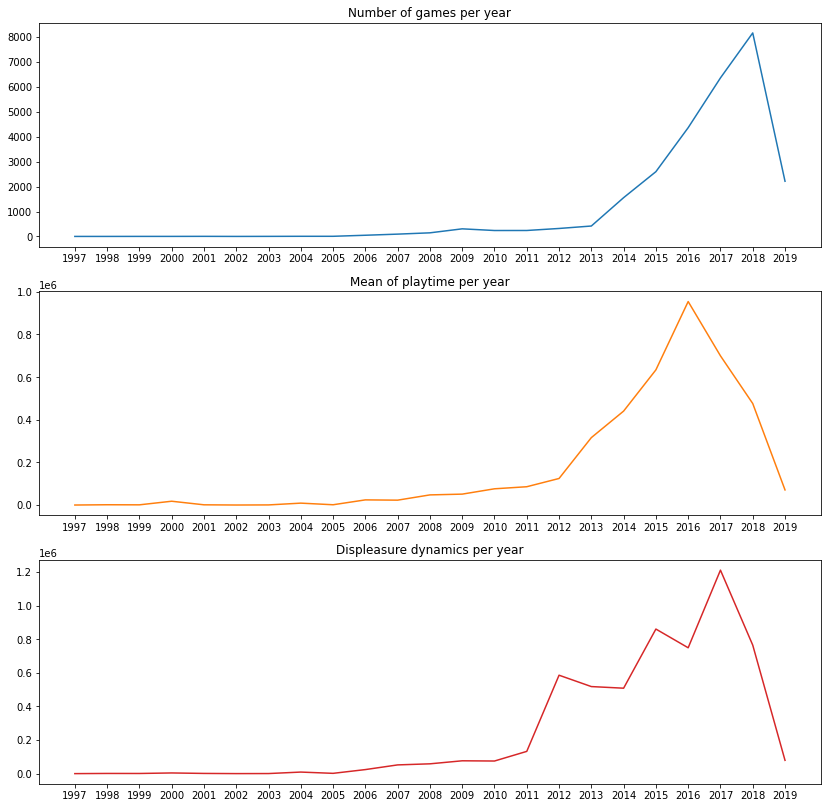

In [30]:
from matplotlib import pyplot as plt
dates = data
dates["release_date"] = dates["release_date"].str.replace("-", " ")
dates["year"] = dates["release_date"].apply(lambda row: row.split()[0])
mean_of_average_playtime_per_year = dates.groupby("year").average_playtime.sum()
displeasure_per_year = dates.groupby("year").negative_ratings.sum()
number_of_games_per_year = dates.year.value_counts().sort_index()
years = pd.Series(dates["year"].unique()).sort_values()
fig, axs = plt.subplots(3, figsize=[14,14])
axs[0].set_title("Number of games per year")
axs[0].plot(years, number_of_games_per_year)
axs[1].set_title("Mean of playtime per year")
axs[1].plot(years, mean_of_average_playtime_per_year, 'tab:orange')
axs[2].set_title("Displeasure dynamics per year")
axs[2].plot(years, displeasure_per_year, "tab:red")
plt.show()


# 9) Select the mid50% (interquartile range) of games in average playtime columnm, then apply a corresponding lable to every single entry in average playtime & price columns in order to apply multigrouping

In [31]:
nonzero_data = data[(data.average_playtime != 0)]
interquartiled_data = nonzero_data[(nonzero_data.average_playtime > nonzero_data.average_playtime.quantile(0.25)) & (nonzero_data.average_playtime < nonzero_data.average_playtime.quantile(0.75))]
interquartiled_data.set_index("name")
#interquartiled_data["satisfaction"] = interquartiled_data.average_playtime.map(lambda hours: "high" if hours >= 250 else "little "if hours <= 100 else "mid")
interquartiled_data.loc[:, ("satisfaction")] = interquartiled_data.loc[:, ("average_playtime")].map(lambda hours: "high" if hours >= 250 else "little "if hours <= 100 else "mid")
interquartiled_data.loc[:, ("price_grade")] = interquartiled_data.loc[:, ("price")].map(lambda num: "below 10 pounds" if num < 10 else "30+ pounds" if num >= 30 else "10 to 30 pounds")
interquartiled_data = interquartiled_data.groupby(["satisfaction", "price_grade"]).agg({"name":"count", "price":"mean"})

interquartiled_data

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


name      price
satisfaction price_grade                     
high         10 to 30 pounds   197  15.373096
             30+ pounds         13  39.913077
             below 10 pounds   876   3.711450
little       10 to 30 pounds    54  15.399259
             30+ pounds          5  38.790000
             below 10 pounds   163   3.632883
mid          10 to 30 pounds   339  15.128643
             30+ pounds         15  38.722667
             below 10 pounds  1411   3.491573

##Conclusion: games with satisfaction >= mid and which cost more than 10 pounds need to be promoted. In this way, we can increase the number of new players, create some rewards for "newbies" and offer special paid gifts in order to increase those games proficiency.

#10) From 2019 (when COVID-19 pandemic started) almost all checkpoints between countries were cancelled. Maybe, it's a good idea to research Adventure & Indie games, especially in retrospective - just to compare growth of their popularity throughout the time. Try to find some clues hidden in the description - all that stuff can be used while creating an eye-catching ad with only one glance on it :)

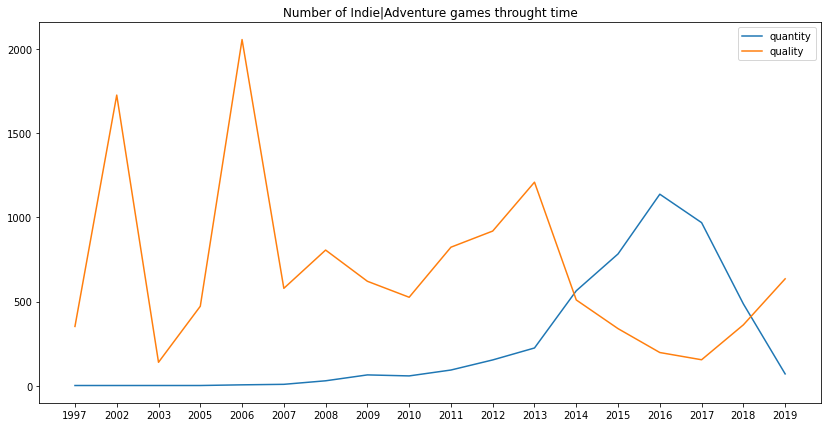

In [32]:
# 1) selecting necessary data data.apply(lambda row: row.genres.split()[0], axis="columns")
to_process = data[(data.genres.str.contains("Indie|Adventure")) & (data.average_playtime != 0)]
number_of_games = to_process["release_date"].apply(lambda row: row.split()[0]).rename("year").value_counts().sort_index()
positive_ratings_growth = to_process[["year", "positive_ratings"]].groupby("year").median().sort_index()
ids_of_corresponding_games = to_process["appid"]
y = list(number_of_games)
x = list(number_of_games.index)
plt.figure(figsize=[14,7])
plt.title("Number of Indie|Adventure games throught time")
plt.plot(x, y, label="quantity")
plt.plot(x, positive_ratings_growth, label="quality")
plt.legend()
plt.show()

In [33]:
desc = pd.read_csv("steam_description_data.csv")
ids_of_corresponding_games.rename("steam_appid")
matching_ids = desc.loc[desc.steam_appid.isin(ids_of_corresponding_games)]
matching_ids #we got descriptions of Indie|Adventure games in the description table

,steam_appid,detailed_description,about_the_game,short_description
23,620,Portal 2 draws from the award-winning formula ...,Portal 2 draws from the award-winning formula ...,The &quot;Perpetual Testing Initiative&quot; h...
30,1500,Combining fast-paced action with strategic bat...,Combining fast-paced action with strategic bat...,Combining fast-paced action with strategic bat...
31,1510,You play an Uplink Agent who makes a living by...,You play an Uplink Agent who makes a living by...,You play an Uplink Agent who makes a living by...
32,1520,"Inspired by the 1983 cult classic film, Wargam...","Inspired by the 1983 cult classic film, Wargam...","Inspired by the 1983 cult classic film, Wargam..."
33,1530,&quot;Long ago a computer scientist called Dr ...,&quot;Long ago a computer scientist called Dr ...,&quot;Long ago a computer scientist called Dr ...
...,...,...,...,...
26607,1014440,"<h2 class=""bb_tag"">characterization</h2><br>『M...","<h2 class=""bb_tag"">characterization</h2><br>『M...","Casual decompression game, easy to experience ..."
26718,1020340,"Audica is a VR Rhythm Shooter from Harmonix, t...","Audica is a VR Rhythm Shooter from Harmonix, t...",Audica™ is a VR “rhythm shooter” that combines...
26937,1031480,"<h2 class=""bb_tag"">ABOUT THIS GAME</h2><img sr...","<h2 class=""bb_tag"">ABOUT THIS GAME</h2><img sr...",Touhou Makuka Sai ~ Fantastic Danmaku Festival...
27115,1043180,"<img src=""https://steamcdn-a.akamaihd.net/stea...","<img src=""https://steamcdn-a.akamaihd.net/stea...",Are you tired of fighting? Lovers of Aether is...


In [34]:
matching_ids = matching_ids.short_description.str.split()
matching_ids = matching_ids.reset_index(drop=True)
matching_ids

0       [The, &quot;Perpetual, Testing, Initiative&quo...
1       [Combining, fast-paced, action, with, strategi...
2       [You, play, an, Uplink, Agent, who, makes, a, ...
3       [Inspired, by, the, 1983, cult, classic, film,...
4       [&quot;Long, ago, a, computer, scientist, call...
                              ...                        
4643    [Casual, decompression, game,, easy, to, exper...
4644    [Audica™, is, a, VR, “rhythm, shooter”, that, ...
4645    [Touhou, Makuka, Sai, ~, Fantastic, Danmaku, F...
4646    [Are, you, tired, of, fighting?, Lovers, of, A...
4647    [Paper, Dolls, Original, is, a, first-person, ...
Name: short_description, Length: 4648, dtype: object

In [35]:
result = []
for i in range(0, len(matching_ids)):
  result.extend(matching_ids.loc[i])

from collections import Counter

word_counts = Counter(result)
words = pd.Series(word_counts)
most_used = words.sort_values(ascending=False)[39:200]

most_used[most_used.index.str.len() >= 6].head(20)

action         271
unique         268
puzzle         265
against        204
players        202
different      195
shooter        195
classic        181
multiplayer    175
mysterious     168
arcade         156
experience     151
player         150
world.         145
explore        143
platformer     141
online         140
strategy       140
control        134
friends        130
dtype: int64

#Conclusion: Mysterious world is waiting for you to explore. Classic arcade with new multiplayer experience - create a strategy with your friends against another players! Solve puzzles to achieve control. Start playing now! ^_^